<h1> STEP 1: Import libraries and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load your CSV file
df = pd.read_csv('C:/Users/anasl/Desktop/Daten 1/Daten/Output Data/Weather_Master_Data.csv')  # Change to your file path
print(f"Data loaded: {len(df)} rows")

Data loaded: 269160 rows


C:\Users\anasl\AppData\Local\Temp\ipykernel_26460\1393692179.py:5: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:/Users/anasl/Desktop/Daten 1/Daten/Output Data/Weather_Master_Data.csv')  # Change to your file path


<h1> STEP 2: Show available stations

In [2]:
stations = df['Standort'].unique()
print(f"Available stations ({len(stations)}):")
for i, station in enumerate(stations):
    print(f"{i+1:3d}. {station}")

Available stations (214):
  1. Aachen-Orsbach
  2. Ahaus
  3. Alfeld
  4. Andernach
  5. Angermünde
  6. Arkona
  7. Artern
  8. Augsburg
  9. Balingen-Bronnhaupten
 10. Bamberg
 11. Barth
 12. Baruth
 13. Belm
 14. Berge
 15. Berlin Brandenburg
 16. Berlin-Dahlem (FU)
 17. Berlin-Tegel
 18. Berlin-Tempelhof
 19. Bertsdorf-Hörnitz
 20. Berus
 21. Boizenburg
 22. Boltenhagen
 23. Braunlage
 24. Braunschweig
 25. Bremen
 26. Bremerhaven
 27. Bremervörde
 28. Brocken
 29. Carlsfeld
 30. Chemnitz
 31. Chieming
 32. Cottbus
 33. Cuxhaven
 34. Deuselbach
 35. Diepholz
 36. Doberlug-Kirchhain
 37. Dresden-Klotzsche
 38. Dörnick
 39. Dörpen
 40. Düsseldorf
 41. Eisenach
 42. Elpersbüttel
 43. Emden
 44. Erfurt-Weimar
 45. Essen-Bredeney
 46. Faßberg
 47. Fehmarn
 48. Feldberg/Mecklenburg
 49. Feldberg/Schwarzwald
 50. Feuchtwangen-Heilbronn
 51. Fichtelberg
 52. Fichtelberg/Oberfranken-Hüttstadl
 53. Frankfurt/Main
 54. Freiburg
 55. Freudenstadt
 56. Friesoythe-Altenoythe
 57. Fürstenzell
 58

<h1> STEP 3: Select station and process data

In [56]:
# Replace with actual station name

selected_station = 'Öhringen'  

# Filter and process data
station_data = df[df['Standort'] == selected_station].copy()
station_data['Datum'] = pd.to_datetime(station_data['Datum'], format='%d/%m/%Y')
station_data['YearMonth'] = station_data['Datum'].dt.to_period('M')

# Calculate monthly averages
monthly_data = station_data.groupby('YearMonth').agg({
    'MinTemp': 'mean',
    'AvgTemp': 'mean', 
    'MaxTemp': 'mean'
}).reset_index()

monthly_data['Date'] = monthly_data['YearMonth'].dt.to_timestamp()
print(f"Processing complete: {len(monthly_data)} months of data")

Processing complete: 64 months of data


<h1> # STEP 4: Create chart

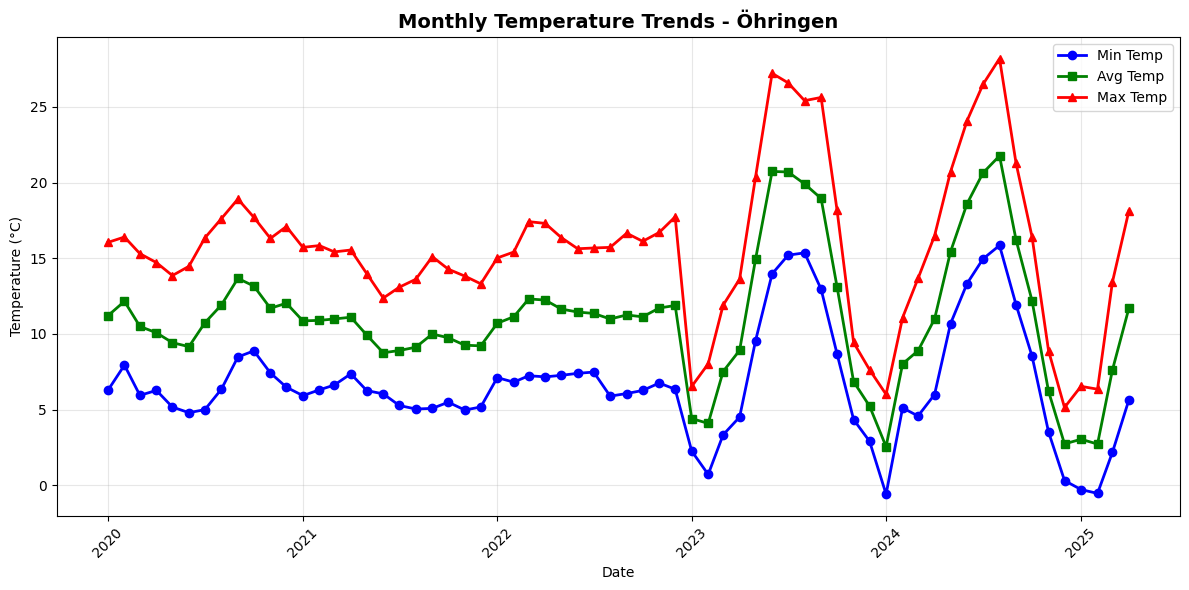

In [57]:
plt.figure(figsize=(12, 6))

# Plot temperature lines
plt.plot(monthly_data['Date'], monthly_data['MinTemp'], 'b-o', label='Min Temp', linewidth=2)
plt.plot(monthly_data['Date'], monthly_data['AvgTemp'], 'g-s', label='Avg Temp', linewidth=2)
plt.plot(monthly_data['Date'], monthly_data['MaxTemp'], 'r-^', label='Max Temp', linewidth=2)

# Format chart
plt.title(f'Monthly Temperature Trends - {selected_station}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# <h1>STEP 5.1 – Prepare daily data for extreme heat conditions

This step:
- Adds 4 Boolean columns to indicate whether each day is a:
  - Hitzetag (hot day)
  - Tropennacht (tropical night)
  - Wärmestau-Tag (heat accumulation)
  - Unkomfortable Tag (uncomfortable day)
- Adds month and year columns for grouping


In [58]:
# Add day, month, and year
station_data['Year'] = station_data['Datum'].dt.year
station_data['Month'] = station_data['Datum'].dt.month

# Identify days based on thresholds
station_data['Hitzetage'] = station_data['MaxTemp'] >= 30
station_data['Tropennächte'] = station_data['MinTemp'] >= 25
station_data['Wärmestau'] = station_data['AvgTemp'].rolling(window=3).mean() >= 25

# Uncomfortable = any of the above
station_data['Unkomfortable'] = (
    station_data['Hitzetage'] |
    station_data['Tropennächte'] |
    station_data['Wärmestau']
)


# <h1>STEP 5.2 – Bar chart: Min / Mean / Max days per month

In this step, we:
- Count how many days per month and year meet each condition
- Calculate for each month:
  - Minimum number of days (in any year)
  - Mean number of days (over 5 years)
  - Maximum number of days (in any year)
- Plot this in grouped bar charts with error bars (min/mean/max)


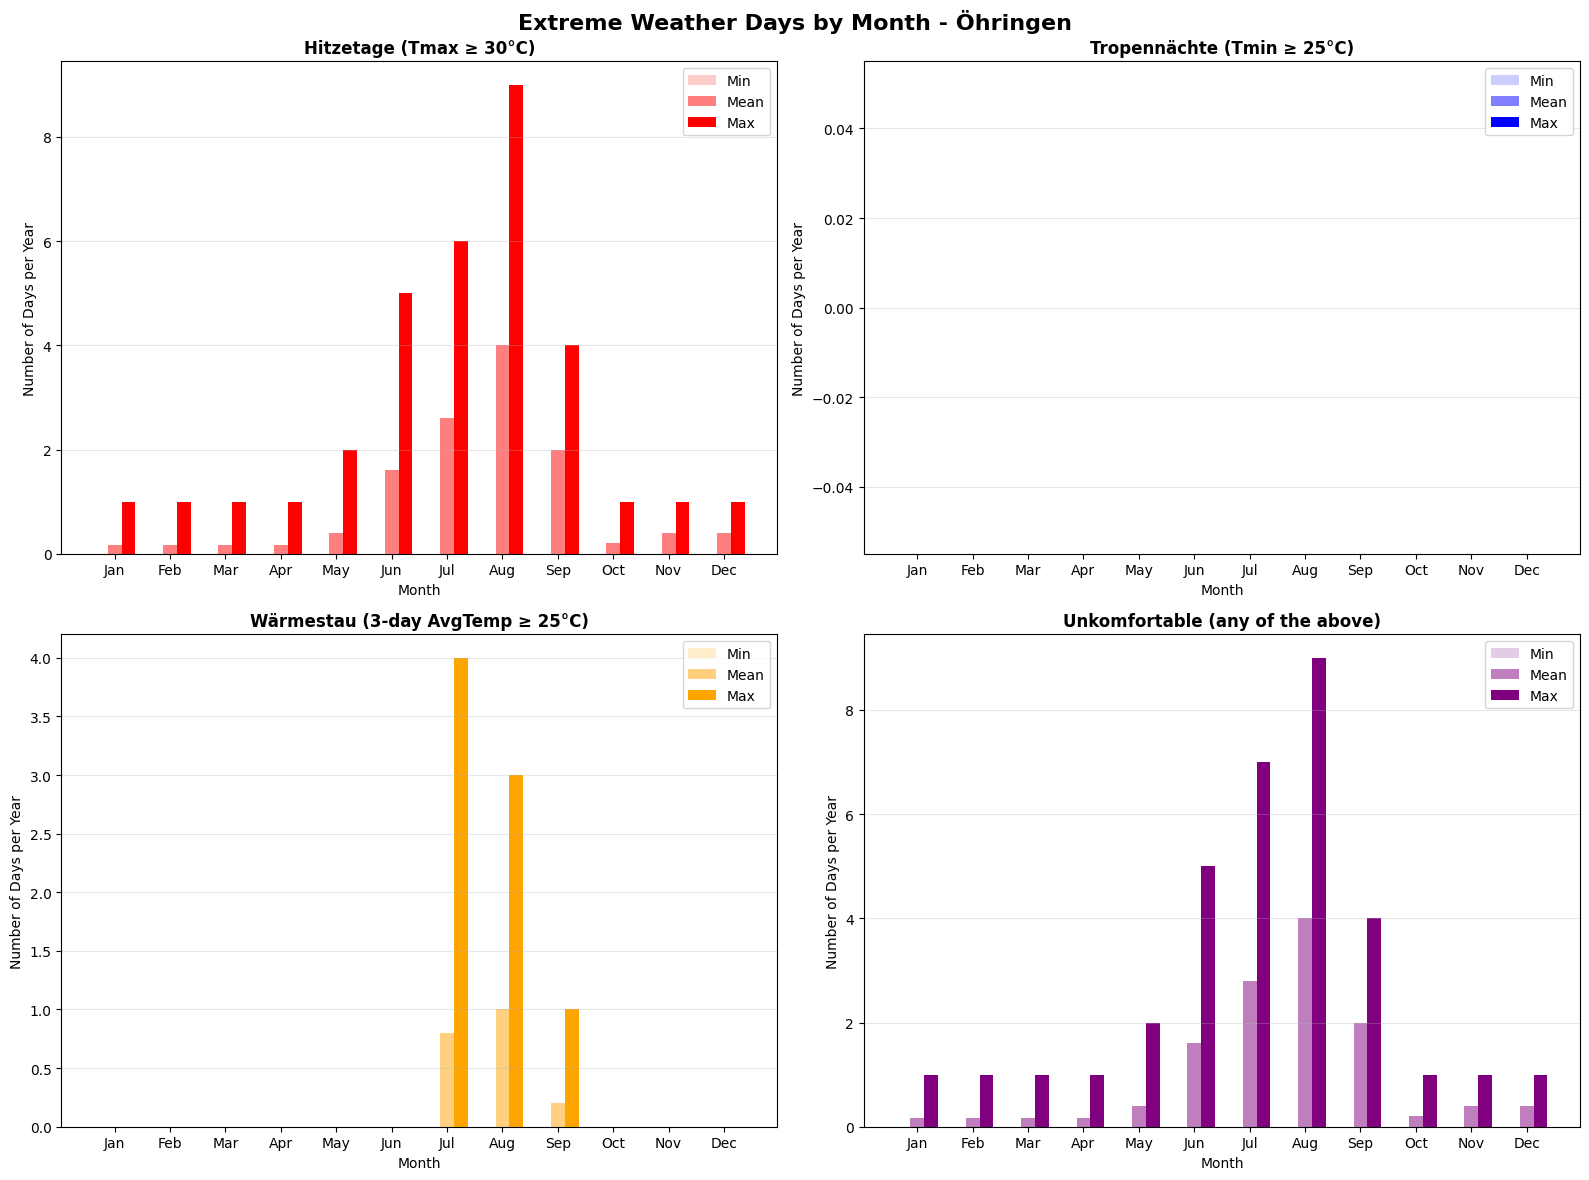

In [63]:
# Group by year and month to count matching days
monthly_counts = station_data.groupby(['Year', 'Month']).agg({
    'Hitzetage': 'sum',
    'Tropennächte': 'sum',
    'Wärmestau': 'sum',
    'Unkomfortable': 'sum'
}).reset_index()

# Compute min, mean, and max for each month
summary = monthly_counts.groupby('Month').agg(['min', 'mean', 'max'])

# Set up for plotting
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(12)
width = 0.25

# Categories and colors
categories = ['Hitzetage', 'Tropennächte', 'Wärmestau', 'Unkomfortable']
colors = ['red', 'blue', 'orange', 'purple']
titles = [
    'Hitzetage (Tmax ≥ 30°C)',
    'Tropennächte (Tmin ≥ 25°C)', 
    'Wärmestau (3-day AvgTemp ≥ 25°C)',
    'Unkomfortable (any of the above)'
]

# Create 4 separate subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (cat, color, title) in enumerate(zip(categories, colors, titles)):
    ax = axes[idx]
    
    # Get min, mean, max values for this category
    mins = summary[cat]['min'].values
    means = summary[cat]['mean'].values
    maxs = summary[cat]['max'].values
    
    # Create three bars per month (min, mean, max)
    ax.bar(x - width, mins, width, label='Min', color=color, alpha=0.2)
    ax.bar(x, means, width, label='Mean', color=color, alpha=0.5)
    ax.bar(x + width, maxs, width, label='Max', color=color, alpha=1.0)
    
    # Format each subplot
    ax.set_xticks(x)
    ax.set_xticklabels(months)
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Days per Year')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

# Overall title
fig.suptitle(f'Extreme Weather Days by Month - {selected_station}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

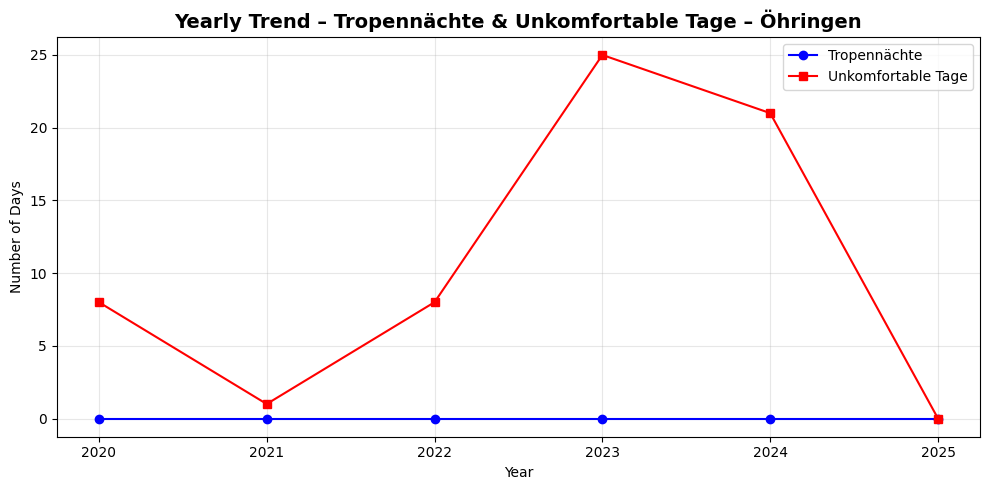

In [64]:
# Yearly totals for selected categories
yearly_totals = station_data.groupby('Year').agg({
    'Tropennächte': 'sum',
    'Unkomfortable': 'sum'
}).reset_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(yearly_totals['Year'], yearly_totals['Tropennächte'], 'b-o', label='Tropennächte')
plt.plot(yearly_totals['Year'], yearly_totals['Unkomfortable'], 'r-s', label='Unkomfortable Tage')

plt.title(f'Yearly Trend – Tropennächte & Unkomfortable Tage – {selected_station}', fontsize=14, fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Number of Days')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
